In [25]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense ,Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier, KerasRegressor
from sklearn.metrics import mean_absolute_error

import pandas as pd
import numpy as np

df_all_data = pd.read_csv("../data/climate/AMOCdata.csv")

def preprocess_data(df):
    # Dropping unnecessary columns
    columns_to_drop = ['AMOC1', 'AMOC2', 'GM','time']
    df = df.drop(columns=columns_to_drop)
    
    return df

all_data = preprocess_data(df_all_data)
all_data['DateTime'] = pd.to_datetime(all_data['date'])
all_data = all_data.drop(columns=['date'])

test = all_data[1000:1250]

In [21]:
# Rename date into DateTime
all_data

,AMOC0,DateTime
0,0.163951,1870-01-31
1,0.313431,1870-03-02
2,0.204185,1870-04-02
3,0.141020,1870-05-02
4,0.058445,1870-06-02
...,...,...
1807,0.353692,2020-08-31
1808,0.327049,2020-09-30
1809,0.254533,2020-10-31
1810,-0.053814,2020-11-30


# simple without optimazation

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

df = all_data
df.set_index('DateTime', inplace=True)

# minmax normalize the dataset
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Splitting into training and test sets
train_size = 1000
test_size = 250
train = scaled_data[:train_size]
test = scaled_data[train_size:train_size + test_size]

# Extract datetime for the test set
test_dates = df.index[train_size:train_size + test_size]

# Convert to the appropriate shape for LSTM
def create_dataset(dataset, look_back=50):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 50
trainX, trainY = create_dataset(train, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

# Building the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Training the model
model.fit(trainX, trainY, epochs=2, batch_size=1, verbose=2)

# Function to predict and move with a rolling window (with one timestep increment)
def rolling_window_prediction(model, train_data, test_data, test_dates, look_back, num_predictions=50):
    predictions = []
    actuals = []
    dates = []
    roll_numbers = []

    roll_number = 0

    # Concatenate train and test data
    full_data = np.concatenate((train_data, test_data))
    full_dates = np.concatenate((df.index[:train_size], test_dates))

    # Start rolling from the 50th last point of train data
    start_index = len(train_data) - look_back

    for i in range(start_index, len(full_data) - look_back - num_predictions + 1):
        roll_number += 1

        # Prepare input data including the look back window from full data
        input_data = full_data[i:i + look_back]
        input_data = input_data.reshape((1, look_back, 1))

        # Generate predictions for the next `num_predictions` time steps
        for step in range(num_predictions):
            if i + look_back + step >= len(full_data):  # Ensure not to exceed array bounds
                break

            predicted = model.predict(input_data)
            predictions.append(predicted.flatten()[0])
            actuals.append(full_data[i + look_back + step, 0])
            dates.append(full_dates[i + look_back + step])
            roll_numbers.append(roll_number)

            # Append the predicted value to the input_data for the next prediction
            input_data = np.append(input_data[:, 1:], predicted.reshape(1, 1, 1), axis=1)

    return np.array(predictions), np.array(actuals), dates, roll_numbers

# Execute rolling window prediction
preds, trues, preds_dates, roll_numbers = rolling_window_prediction(model, train, test, test_dates, look_back, num_predictions=50)

# Convert lists to pandas DataFrame
results_df = pd.DataFrame({
    'DateTime': preds_dates,
    'Predicted': scaler.inverse_transform(preds.reshape(-1, 1)).flatten(),
    'Actual': scaler.inverse_transform(trues.reshape(-1, 1)).flatten(),
    'RollNumber': roll_numbers
})

results_df.set_index('DateTime', inplace=True)

print(results_df.head())
print('Number of predictions:', len(results_df))

# optimized parameters

In [26]:
df = all_data
df.set_index('DateTime', inplace=True)

# Normalize the dataset
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Split into training and test sets
train_size = 100
test_size = 250
predictions_ahead = 50

train = scaled_data[:train_size]
test = scaled_data[train_size:train_size + test_size]

# Extract datetime for the test set
test_dates = df.index[train_size:train_size + test_size]

# Convert to the appropriate shape for LSTM
def create_dataset(dataset, look_back=50):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 50
trainX, trainY = create_dataset(train, look_back)

# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))

# Split trainX and trainY for training and validation
val_size = int(trainX.shape[0] * 0.2)
valX, valY = trainX[:val_size], trainY[:val_size]
trainX, trainY = trainX[val_size:], trainY[val_size:]

# Build and optimize the LSTM model
model = Sequential()
model.add(LSTM(64, return_sequences=True, input_shape=(look_back, 1)))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Using earlystopping here to prevent overfitting (it stops training when the validation loss stops decreasing for more than [patience] epochs)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
model.fit(trainX, trainY, epochs=100, batch_size=1, validation_data=(valX, valY), callbacks=[early_stop], verbose=2)

# Function to predict and move with a rolling window (with one timestep increment)
def rolling_window_prediction(model, train_data, test_data, test_dates, look_back, num_predictions):
    predictions = []
    actuals = []
    dates = []
    roll_numbers = []

    roll_number = 0

    # Concatenate train and test data
    full_data = np.concatenate((train_data, test_data))
    full_dates = np.concatenate((df.index[:train_size], test_dates))

    # Start rolling from the 50th last point of train data
    start_index = len(train_data) - look_back

    for i in range(start_index, len(full_data) - look_back - num_predictions + 1):
        roll_number += 1

        # Prepare input data including the look back window from full data
        input_data = full_data[i:i + look_back]
        input_data = input_data.reshape((1, look_back, 1))

        # Generate predictions for the next `num_predictions` time steps
        for step in range(num_predictions):
            if i + look_back + step >= len(full_data):  
                break

            predicted = model.predict(input_data)
            predictions.append(predicted.flatten()[0])
            actuals.append(full_data[i + look_back + step, 0])
            dates.append(full_dates[i + look_back + step])
            roll_numbers.append(roll_number)

            # Append the predicted value to the input_data for the next prediction
            input_data = np.append(input_data[:, 1:], predicted.reshape(1, 1, 1), axis=1)

    return np.array(predictions), np.array(actuals), dates, roll_numbers

# Executing rolling prediction function made above
preds, trues, preds_dates, roll_numbers = rolling_window_prediction(model, train, test, test_dates, look_back, num_predictions=predictions_ahead)

# Convert lists to pandas DataFrame
results_df = pd.DataFrame({
    'DateTime': preds_dates,
    'Predicted': scaler.inverse_transform(preds.reshape(-1, 1)).flatten(),
    'Actual': scaler.inverse_transform(trues.reshape(-1, 1)).flatten(),
    'RollNumber': roll_numbers
})

results_df.set_index('DateTime', inplace=True)

print(results_df.head())
print('Number of predictions:', len(results_df))

# results to csv
results_df.to_csv(f'results/climate_data/train_{train_size}_test_{test_size}_horizon_{predictions_ahead}_results.csv')

Epoch 1/100


/Users/wibe/Documents/Skole/UNI_CogSci/8_semester/Data Science/data_science_exam_24/venv_data_science_exam/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


40/40 - 1s - 31ms/step - loss: 0.0319 - val_loss: 0.0018
Epoch 2/100
40/40 - 0s - 8ms/step - loss: 0.0058 - val_loss: 0.0040
Epoch 3/100
40/40 - 0s - 9ms/step - loss: 0.0053 - val_loss: 0.0025
Epoch 4/100
40/40 - 0s - 8ms/step - loss: 0.0044 - val_loss: 0.0026
Epoch 5/100
40/40 - 0s - 9ms/step - loss: 0.0049 - val_loss: 0.0019
Epoch 6/100
40/40 - 0s - 9ms/step - loss: 0.0040 - val_loss: 0.0025
Epoch 7/100
40/40 - 0s - 9ms/step - loss: 0.0043 - val_loss: 0.0018
Epoch 8/100
40/40 - 0s - 8ms/step - loss: 0.0035 - val_loss: 0.0043
Epoch 9/100
40/40 - 0s - 8ms/step - loss: 0.0048 - val_loss: 0.0050
Epoch 10/100
40/40 - 0s - 9ms/step - loss: 0.0036 - val_loss: 0.0024
Epoch 11/100
40/40 - 0s - 8ms/step - loss: 0.0038 - val_loss: 0.0041
Epoch 12/100
40/40 - 0s - 8ms/step - loss: 0.0037 - val_loss: 0.0039
Epoch 13/100
40/40 - 0s - 8ms/step - loss: 0.0039 - val_loss: 0.0027
Epoch 14/100
40/40 - 0s - 8ms/step - loss: 0.0050 - val_loss: 0.0024
Epoch 15/100
40/40 - 0s - 8ms/step - loss: 0.0039 - va

In [13]:
# save results
results_df.to_csv(f'results/climate_data/train_{train_size}_test_{test_size}_horizon_{predictions_ahead}_results.csv')

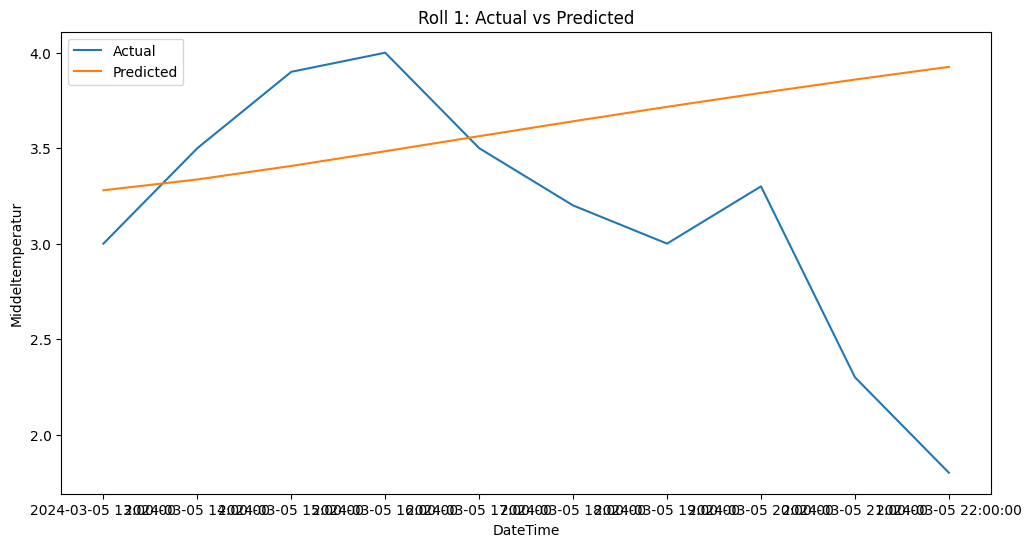

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

roll_1 = results_df[results_df['RollNumber'] == 10]

plt.figure(figsize=(12, 6))
sns.lineplot(x=roll_1.index, y=roll_1['Actual'], label='Actual')
sns.lineplot(x=roll_1.index, y=roll_1['Predicted'], label='Predicted')
plt.title('Roll 1: Actual vs Predicted')
plt.xlabel('DateTime')
plt.ylabel('Middeltemperatur')
plt.legend()
plt.show()
